This notebook demonstrates filtering and reprojection of point cloud at a given viewpoint with camera metadata.

In [413]:
import numpy as np
from PIL import Image, ImageDraw
import laspy
from matplotlib import pyplot as plt
from pyproj import Transformer
from scipy.spatial.transform import Rotation as R
from lidar.point_cloud_processings import remove_noise

In [415]:
def project_lidar_perspective(point_cloud, position, orientation,resolution, fov, no_data_value=-9999):
    """
    Project LiDAR point cloud onto a 2D perspective image and calculate an elevation map.

    Parameters:
        point_cloud (numpy.ndarray): Nx3 array of LiDAR points (x, y, z) in EPSG:28355 and GDA1994 height datum.
        position (tuple): (longitude, latitude, height) of the camera position in EPSG:4326 and GDA1994 height datum.
        orientation (tuple): Viewpoint orientation as a 3-tuple (yaw, pitch, roll in radians).
        resolution (tuple): Image resolution (width, height).
        fov (float): Horizontal field of view in degrees.

    Returns:
        numpy.ndarray: 2D elevation map, averaged within each pixel grid.
    """
    # Unpack inputs
    px, py, pz = point_cloud.T  # Point cloud coordinates
    vx, vy, vz = position  # Viewpoint position
    yaw, pitch, roll = orientation  # Viewpoint orientation
    img_width, img_height = resolution  # Image resolution

    # Step 1: Translate points to the viewpoint's position
    points = np.array([px - vx, py - vy, pz - vz]).T

    # Step 2: Apply rotation to align with the viewpoint's orientation
    rotation_matrix = R.from_euler('zyx', [yaw, pitch, roll]).as_matrix()
    points = points @ rotation_matrix.T
    

    print('total number of points: ',len(points))
    points = np.asarray(points)

    # Perspective projection parameters
    focal_length = 0.5 * img_width / np.tan(0.5 * fov)

    # Filter points in front of the camera (z > 0)
    x, y, z = points.T
    valid = z > 0
    x, y, z = x[valid], y[valid], z[valid]
    print('number of points in front of camera: ',np.sum(valid))

    # Project to image plane
    u = (focal_length * x / z + img_width / 2).astype(int)
    v = (focal_length * y / z + img_height / 2).astype(int)

    print('u: ',u)
    print('v: ',v)
    print('z: ',z)
    # Clip points to be within image bounds
    valid_pixels = (u >= 0) & (u < img_width) & (v >= 0) & (v < img_height)
    print('number of points within view: ',np.sum(valid_pixels))
    print(valid_pixels)
    u, v, z = u[valid_pixels], v[valid_pixels], z[valid_pixels]

    # Create an elevation map and track counts for averaging
    elevation_map = np.zeros((img_height, img_width), dtype=np.float32)
    counts = np.zeros((img_height, img_width), dtype=np.int32)

    for px, py, z_val in zip(u, v, z):
        elevation_map[py, px] += z_val  # Accumulate elevation values
        counts[py, px] += 1            # Count the number of points per pixel

    # Avoid division by zero and calculate the average elevation
    non_zero = counts > 0
    elevation_map[non_zero] /= counts[non_zero]

    # Replace zero or invalid elevation values with a no-data value (e.g., -1 for invalid elevation)
    elevation_map[~non_zero] = no_data_value

    return elevation_map

In [416]:
def project_lidar_equirectangular(point_cloud, position, orientation, hfov, vfov, resolution,no_data_value=-9999):
    """
    Calculate an elevation image from a point cloud projected within the field of view.

    Parameters:
        point_cloud (numpy.ndarray): Array of shape (N, 3) with 3D points (x, y, z).
        position (tuple): Viewpoint position as a 3-tuple (x, y, z).
        orientation (tuple): Viewpoint orientation as a 3-tuple (yaw, pitch, roll in radians).
        hfov (float): Horizontal field of view in radians.
        vfov (float): Vertical field of view in radians.
        resolution (tuple): Image resolution (width, height).

    Returns:
        numpy.ndarray: 2D array representing the elevation image.
    """
    # Unpack inputs
    px, py, pz = point_cloud.T  # Point cloud coordinates
    vx, vy, vz = position  # Viewpoint position
    yaw, pitch, roll = orientation  # Viewpoint orientation
    img_width, img_height = resolution  # Image resolution

    # Step 1: Translate points to the viewpoint's position
    points = np.array([px - vx, py - vy, pz - vz]).T

    # Step 2: Apply rotation to align with the viewpoint's orientation
    rotation_matrix = R.from_euler('zyx', [yaw, pitch, roll]).as_matrix()
    points = points @ rotation_matrix.T

    print('total number of points: ',len(points))
    print('transformed points: ',points)
    # Step 3: Convert to spherical coordinates
    r = np.linalg.norm(points, axis=1)  # Radial distance
    theta = np.arctan2(points[:, 1], points[:, 0])  # Azimuth angle
    phi = np.arcsin(points[:, 2] / r)  # Elevation angle

    # Step 4: Filter points within the field of view
    mask = (
        (theta >= -hfov / 2) & (theta <= hfov / 2) &
        (phi >= -vfov / 2) & (phi <= vfov / 2)
    )
    print('number of points within view: ',np.sum(mask))
    points = points[mask]
    theta = theta[mask]
    phi = phi[mask]
    r = r[mask]

    # Step 5: Map to image plane
    u = ((theta + hfov / 2) / hfov * img_width).astype(int)
    v = ((phi + vfov / 2) / vfov * img_height).astype(int)

    print('u: ',u)
    print('v: ',v)
    u = np.clip(u, 0, img_width - 1)
    v = np.clip(v, 0, img_height - 1)

    print('u clipped: ',u)
    print('v clipped: ',v)

    # Step 6: Create the elevation image
    elevation_image = np.full((img_height, img_width), no_data_value,dtype=float)
    for ui, vi, ri in zip(u, v, points[:, 2]):
        elevation_image[vi, ui] = max(elevation_image[vi, ui], ri)  # Max elevation

    return elevation_image


### Read LiDAR points from a .las file

In [417]:
las_file_path = r"C:\Users\lliu\Desktop\FrontierSI\projects\GA_floor_height\QA4lidar\2_clipped_buffered.las"
with laspy.open(las_file_path) as las:
    lidar_data = las.read()
    lidar_points = np.vstack((lidar_data.x, lidar_data.y, lidar_data.z)).T  # Extract x, y, z coordinates


total number of points:  9949
number of points in front of camera:  9949
u:  [ 954 1627 1527 ... 1326 1348 1376]
v:  [129 129 135 ...  99  95  98]
z:  [3.22 1.65 1.77 ... 3.32 3.35 3.29]
number of points within view:  0
[False False False ... False False False]


array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)

### Filter point cloud

In [ ]:
# Remove noise points using DBSCAN
eps = 3  # Maximum distance between points to be considered neighbors (meters)
min_samples = 2  # Minimum number of points to form a cluster
lidar_points = remove_noise(lidar_points, eps, min_samples)

### Set camera metadata


In [ ]:
# Camera in EPSG:4326 (longitude, latitude, height)
camera_position = (149.1728570, -21.1282603, 7)  
yaw = np.radians(250)         # Camera yaw angle
pitch = np.radians(0)        # Camera pitch angle
roll = np.radians(0)         # Camera roll angle
orientation=(yaw, pitch, roll)
# Image dimensions
image_width = 256
image_height = 256
resolution=(image_width,image_height)
# Field of views in degrees
fov_v=np.radians(90)
fov_h = np.radians(90)
# fill value for background pixels
nodata_value=-9999

### Reproject viewpoint to be consistent with point cloud

In [ ]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:28355", always_xy=True)
camera_easting, camera_northing = transformer.transform(camera_position[0], camera_position[1])
camera_position=(camera_easting, camera_northing,camera_position[2])

### project point cloud

In [ ]:
# Project points
elevation_image = project_lidar_perspective(lidar_points, camera_position, orientation, resolution, fov_h,no_data_value=nodata_value)
elevation_image

### Visualise projected image

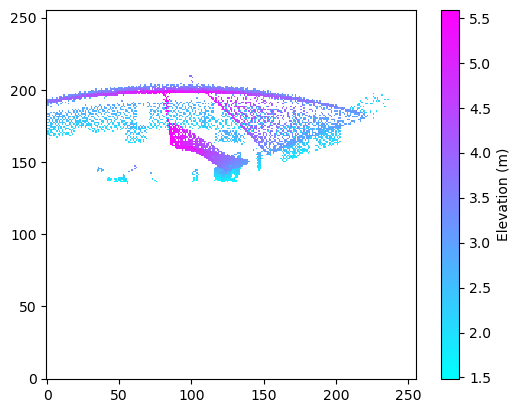

In [372]:
elevation_image_copy=elevation_image.copy()
elevation_image_copy[elevation_image_copy==nodata_value] = np.nan
plt.imshow(elevation_image_copy,cmap='cool',interpolation='none',origin='lower')
plt.colorbar(label='Elevation (m)')